# Тестовое задание направление «Аналитик данных» (Data Analyst), МТС Big Data

##**Задание 1**

**Подключение источников, подготовка данных**

In [1]:
import pandas as pd

#считываем данные из csv (подгружаю из колаба)
df_1 = pd.read_csv('/host_d.csv', sep=';')
df_2 = pd.read_csv('/communication_d.csv', sep=';')



In [2]:
#смотрю общую характеристику данных, проверяю на наличие пропусков

df_1.info()
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5157 entries, 0 to 5156
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   msisdn          5157 non-null   object
 1   request_dt      5157 non-null   object
 2   host            5157 non-null   object
 3   traffic_volume  5157 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 161.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 465 entries, 0 to 464
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   msisdn           465 non-null    object
 1   event_dt         465 non-null    object
 2   application_flg  465 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 11.0+ KB


In [4]:
#делаю left join по таблице communication_d, чтобы учесть условие "по каждому событию из таблицы коммуникаций"
df_merged = pd.merge(df_2, df_1, left_on=['msisdn'], right_on=['msisdn'], how='left')

**Реализация бизнес логики**

In [17]:
#реализую условие: период в 14 дней до дня события (не включая день события)

#задаю формат даты
df_merged['event_dt'] = pd.to_datetime(df_merged['event_dt'])
df_merged['request_dt'] = pd.to_datetime(df_merged['request_dt'])

#фильтрую датасет, чтобы оставить только нужные нам даты.
#Если датасет дейсвтительно большой, то лучше его сразу уменьшить, чтобы оптимизировать ресурсы.

df_merged['day_space'] = (df_merged['event_dt']-df_merged['request_dt']).dt.days #здесь добавили колонку day_space, которая расширила датасет и размножила одни и те же строки
ddf = df_merged[(df_merged['day_space'] < 15)&(df_merged['day_space'] >=0)] #разница между датой ивента и запроса не более 15 дней

print(df_merged.shape, ddf.shape) #смотрю сколько осталось записей

(5157, 7) (1506, 7)


In [18]:
#ddf.head(15)
#столбец day_space больше не нужен и нужно убрать задублированные данные
ddf = ddf.drop(['day_space', 'request_dt'], axis=1)
ddf.shape

(1506, 5)

In [26]:
ddf['msisdn'].nunique() #341 уникальный id

341

In [37]:
#реализую условие: суммарный трафик за последние 14 дней до даты события

report = ddf.copy(deep=False) #создаем отдельную переменную под целевую витрину
report = report.groupby(['msisdn', 'event_dt', 'application_flg', 'host'], as_index=False)['traffic_volume'].sum() #считаем суммарный трафик
report

,msisdn,event_dt,application_flg,host,traffic_volume
0,#abb7c#abb7c0901312,2024-01-29,0,greenbank.ru,258048
1,#abb7c#abb7c0901312,2024-01-29,0,yellowbank.invest.ru,14336
2,#abb7c#abb7c9826432,2024-01-16,0,yellowbank.invest.ru,9216
3,#abb7c#abbc#abbc192#abbc552,2024-01-24,0,greenbank.ru,82944
4,#abb7c#abbc#abbc192#abbc552,2024-01-24,0,yellowbank.invest.ru,2048
...,...,...,...,...,...
396,#abb7c981489152,2024-01-30,0,yellowbank.invest.ru,25600
397,#abb7c990200832,2024-01-21,0,yellowbank.invest.ru,27648
398,#abb7c991245824,2024-01-16,0,yellowbank.invest.ru,23552
399,#abb7c991915008,2024-01-20,0,yellowbank.invest.ru,31744


**Формирование целевой витрины**



In [ ]:
report = report.rename(columns={'traffic_volume': 'sum_traffic_volume'})  #переименовываем колонки как в условии
report.to_csv('/report.csv', index=False) #сохраняем csv

##**Задание 2**

**Какими приложениями банков пользовались новые клиенты МТС Инвестиций?**

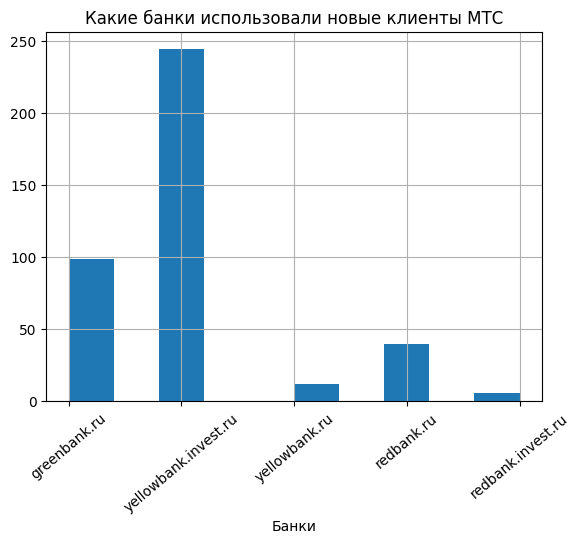

In [38]:
import matplotlib.pyplot as plt

#для ответа на порос посмотрим на гистограму
plt.hist(report['host'], bins = 10)
plt.title("Какие банки использовали новые клиенты МТС")
plt.xlabel("Банки")
plt.xticks(rotation=40)
plt.grid ( True )
plt.show()


In [39]:
report['host'].value_counts(normalize=True) #порой категориальные значения удобнее смотреть этим методом

yellowbank.invest.ru    0.608479
greenbank.ru            0.246883
redbank.ru              0.099751
yellowbank.ru           0.029925
redbank.invest.ru       0.014963
Name: host, dtype: float64

**Какими приложениями банков пользовались новые клиенты МТС Инвестиций?**


---


**Вывод**

* Исходя из построенной гистограммы можно сделать вывод, что чаще всего (с отрывом
от предыдущего банка в 2.5 раза) пользователи yellowbank.invest.ru обращались к МТС Инвестициям. При этом пользователи того же банка, но не использовавшие продукт "Инвестиции" приходили в МТС Инвестиции неохотнее (самый низкий показатель). Вероятно, либо эти пользователи испытывали определенные потребности, которые частично или полностью закрывают предложения МТС Инвестиций, либо они посчитали для себя переход выгодным из-за, например, привлекательных входных предложений. Здесь стоит уточнить были ли для пользователей yellowbank.invest.ru предоставлены особые условия за переход в МТС Инвестиции.
* Вторым оказался greenbank.ru. Поскольку нет данных о том, что пользователи этого банка ранее использовали продукт Инвестиции сложно сказать, было ли это обращение в МТС Инвестиции ради перехода или же они решили впервые для себя попробовать такой продукт, но выбрали не предложение от greenbank.ru, а МТС.
* Пользователи redbank.ru и redbank.invest.ru обращались в МТС не так часто, относительно лидеров. Однако интересно отметить, что тех, кто ранее не использовал продукт "Инвестиции" в своем красном банке, но в итоге решивших попробовать его в МТС оказалось больше, чем тех, кто уже пользовался инвестициями в своем красном банке. Из этого можно сделать вывод, что пользователи redbank.invest.ru видят для себе меньше выгоды в том, чтобы переходить в другой банк.

**Каким приложением пользуются самые заинтересованные в МТС Инвестициях абоненты?**


In [40]:
app_y = report[report['application_flg'] == 1] #посмотрим, сколько пользователей открыли счет после коммуникации
app_y['host'].value_counts()

yellowbank.invest.ru    21
redbank.ru               8
greenbank.ru             6
yellowbank.ru            1
Name: host, dtype: int64

In [41]:
#посчитаем конверсию коммуникация - открытие счета
cnv_overall = round((len(report[report['application_flg'] == 1])/len(report['application_flg']))*100, 1)
print(f'Общая конверсия составила {cnv_overall}%')

for host in report['host'].unique():
  app = report[report['host'] == host]
  cnv = round((len(app[app['application_flg'] == 1])/len(app['application_flg']))*100, 1)
  print(f'Конверсия от пользователей {host} составила {cnv}%')

Общая конверсия составила 9.0%
Конверсия от пользователей greenbank.ru составила 6.1%
Конверсия от пользователей yellowbank.invest.ru составила 8.6%
Конверсия от пользователей yellowbank.ru составила 8.3%
Конверсия от пользователей redbank.ru составила 20.0%
Конверсия от пользователей redbank.invest.ru составила 0.0%


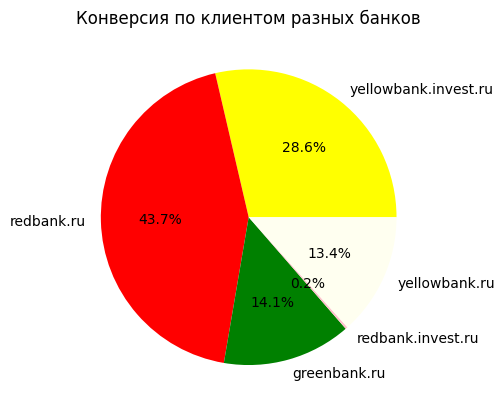

In [42]:
#посмотрим на piechart конверсии
labels = 'yellowbank.invest.ru', 'redbank.ru', 'greenbank.ru', 'redbank.invest.ru', 'yellowbank.ru'
sizes = [12, 18.3, 5.9, 0.1, 5.6]

fig, ax = plt.subplots()
plt.title("Конверсия по клиентом разных банков")
ax.pie(sizes, labels=labels,  autopct='%1.1f%%', colors=['yellow', 'red', 'green', 'pink', 'ivory']);

**Вывод**

---
* Несмотря на то, что исходя из предыдущего пункта самые заинтересованные в переходе в МТС Инвестиции оказались пользователи yellowbank.invest.ru видно, что самые заинтересованные были пользователи redbank.ru. Они чаще всего переходили к ***целевому действию***: заявка на открытие брокерского
счета после коммуникации.
* При этом из обратившихся пользователей redbank.invest.ru после коммуникации никто не создал заявки на открытие брокерского счета. Снова видим, что эти пользователи не видят для себя выгоды в продукте МТС.
* Конверсия пользователей yellowbank.invest.ru заняла второе место, а по обращениям они занимали первое. Можно сделать вывод, что часть клиентов передумали открывать счет, узнав полные условия использования продукта.
* Пользователи greenbank.ru и yellowbank.ru имеют конверсию на одном уровне, однако почти в 2 раза ниже, чем у лидеров. Здесь стоит учесть, что эти клиенты, вероятно, не использовали инвестиции ранее (по крайней мере, они пришли из просто банков), а значит их порог доверия и желание начать заниматься инвестициями могут быть потенциальными причинами таких показателей конверсии.


**Оценим динамику полученных от абонентов данных по дням за данный период**

In [ ]:
pvt = round(pd.pivot_table(report,
		index='host',
		columns='event_dt',
		values='sum_traffic_volume',
		aggfunc='mean',
    fill_value=0))
pvt #посмотрим на сводную таблицу средних значений суммарного трафика по дням

event_dt,2024-01-15,2024-01-16,2024-01-17,2024-01-18,2024-01-19,2024-01-20,2024-01-21,2024-01-22,2024-01-23,2024-01-24,2024-01-25,2024-01-26,2024-01-27,2024-01-28,2024-01-29,2024-01-30,2024-01-31
host,,,,,,,,,,,,,,,,,
greenbank.ru,694365.0,476023.0,196608.0,760724.0,1030144.0,750161.0,498373.0,1107389.0,1132617.0,514121.0,1021347.0,708135.0,1545728.0,246579.0,1637793.0,711765.0,3034843.0
redbank.invest.ru,0.0,97280.0,14336.0,0.0,0.0,0.0,0.0,191488.0,0.0,0.0,2493440.0,0.0,0.0,0.0,5120.0,945152.0,0.0
redbank.ru,0.0,97280.0,305152.0,418475.0,0.0,722944.0,21094.0,1721685.0,31744.0,115968.0,1099776.0,252050.0,23347.0,108032.0,0.0,403456.0,947200.0
yellowbank.invest.ru,22405.0,64637.0,42628.0,84291.0,15591.0,50887.0,33894.0,144302.0,139989.0,41356.0,241290.0,102008.0,415675.0,57583.0,184885.0,126287.0,17883.0
yellowbank.ru,0.0,0.0,14336.0,121856.0,0.0,25600.0,0.0,0.0,575488.0,0.0,1868800.0,268800.0,10240.0,12288.0,685056.0,22528.0,610304.0


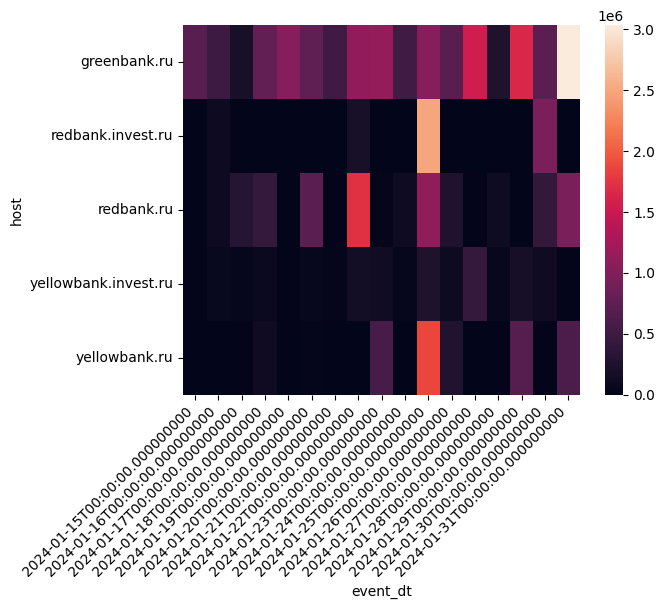

In [ ]:
import seaborn as sns

sns.heatmap(pvt)
plt.xticks(rotation=45, ha='right');

**Выводы**


---
* Несмотря на то, что лидером оказался yellowbank.invest.ru видим, что стабильно высокая динамика трафика пользователей была у greenbank.ru в течении всего временного периода. Пользователи yellowbank.invest.ru также приходили стабильно, однако очевидный скачок можно наблюдать после ивента 20 января.
* Самую неоднородную активность можем наблюдать у пользователей redbank.invest.ru. 25 января был пик пришедшего трафика (хорошо видно на heatmap светло-розовый прямоугольник), этот инвент принес более половины всего трафика за данный период времени.
* Отвечая на вопрос какой ивент дал больше всего лидов стоит отметить, что пики для клиентов разных банков наблюдаются в разные дни. Вероятно, ивенты были точечно направлены на незакрытые потребности каждой из групп. 25 января для yellowbank.ru и redbank.invest.ru, 22ое для redbank.ru. Пик greenbank.ru пришелся на последний доступный для анализа день 31 января. Для yellowbank.invest.ru нельзя дать четкого ответа, активность была однородно стабильной.


#**Общие выводы**


---

Отвечая на вопрос как влияют используемые приложения на интерес к
продукту МТС Инвестиции можно отметить следующее:
* Клиенты, использующее yellowbank.invest.ru чаще всего обращали свое внимание на продукт МТС Инвестиции (объем обращений за исследуемый период). Значит, проводимые МТС Инвестициями ивенты хорошо откликаются у аудитории данного банка и потенциально могут закрыть некоторые их потребности. Здесь следует более детально проанализировать, были ли для клиентуры этого банка особые акции\предложения при переходе к продукту МТС.
* Целевым событием для нашего продукта является заявка на открытие брокерского
счета после коммуникации. Самый высокий показатель по этому пункту у клиентов redbank.ru и yellowbank.invest.ru банков. Видим, что почти половина (43%) клиентов, совершивших целевое действие, это клиенты redbank.ru. Можно предположить, что создание нового ивента, точечно направленного на эту аудиторию, принесет еще больший трафик. Также стоит отметить, что клиенты redbank.ru и yellowbank.invest.ru являются схожими группами клиентов, так как они проявили высокую активность после проведенных ивентов.
* Пользователи greenbank.ru показали среднюю активность как при обращении, так и при совершении целевого действия. Стабильно приходящая после ивентов аудитория показывает, что предложение МТС является для нее привлекательной. Клиенты greenbank.ru очевидная потенциальная точка роста аудитории, на которую стоит обратить внимание.
* Клиенты redbank.invest.ru оказались аутсайдерами. Несмотря на небольшое взаимодействие после ивента, никто из клиентов не открыл брокерский счет. Из этого можно сделать вывод, что предложение МТС Инвестиции является для них непривлекательным. Здесь можно улучшить ситуацию, введя для данной категории клиентов приветственный бонус при переходе в МТС Инвестиции. Однако сначала нужно рассчитать, окупят ли пришедшие пользователи затраты на эту промо акцию.



*Автор: Трещёва Нина (ninatresheva@gmail.com)*